In [1]:
# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from __future__ import division
# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))


import soundtools as st
from bci.core import expstruct as et
from bci.core import kwik_functions as kwkf
from bci import synthetic as syn
from bci import unitmeta as um
from bci import stimalign as sta

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp
#from basic_viewing.structure import kwik_functions as kwf
from decoder import linear as ld


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.debug('all modules loaded')

Computer: passaro


In [4]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-11'
syn_sess = 2
# bird = 'z020'
# sess = 'day-2016-06-03'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')
kwik_file = et.open_kwik(bird, sess)
kwd_file = et.open_kwd(bird, sess)

In [5]:
et.list_sessions(bird)

['day-2016-09-06',
 'day-2016-09-12',
 'day-sleep_2016-09-08',
 'day-2016-09-08',
 'day-2016-09-11',
 'day-2016-09-13',
 'day-audio_test_2016-09-02',
 'day-2016-09-07',
 'day-2016-09-14',
 'day-sleep_2016-09-14',
 'day-2016-09-10',
 'day-sleep_2016-09-09',
 'day-audio_test2_2016-09-02',
 'day-2016-09-09']

In [6]:
reload(et)
prb_par = et.load_probe(bird, sess)
prb_par['channel_groups'][2]['channels']

2017-02-01 10:37:51,692 bci.core.expstruct INFO     probe file: /mnt/cube/earneodo/bci_zf/probes/6c89_0.prb


[2, 3, 4, 5, 6, 7, 8, 12]

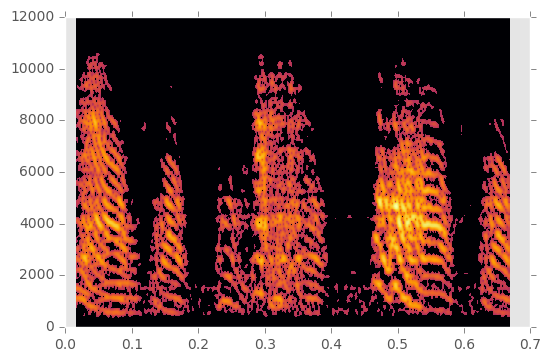

In [7]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
#plt.plot(m_chunk.data)

n_window = 1024
n_overlap = 1023
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*2), 
                                  scaling='spectrum')

pattern_spectrogram[2][[pattern_spectrogram[2]<np.max((pattern_spectrogram[2])*0.000065)]]=1

plt.figure()
plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]),
               cmap='inferno',
              rasterized=True)
fig_fname = os.path.join(os.path.split(m_path)[0], 'motiff_spectrogram_copper.eps')
plt.savefig(fig_fname, format='eps', dpi=300)

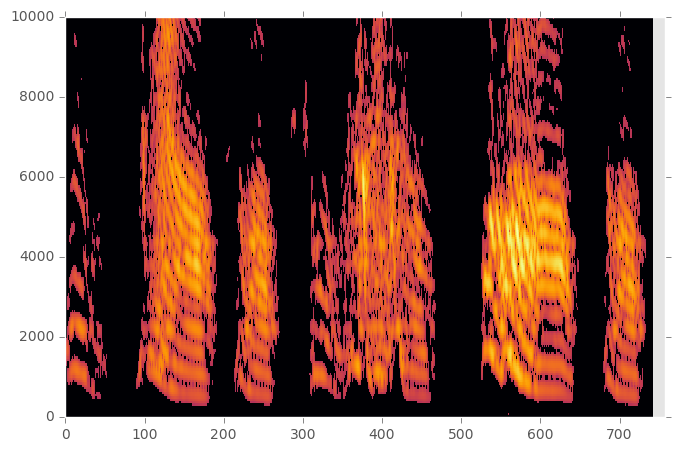

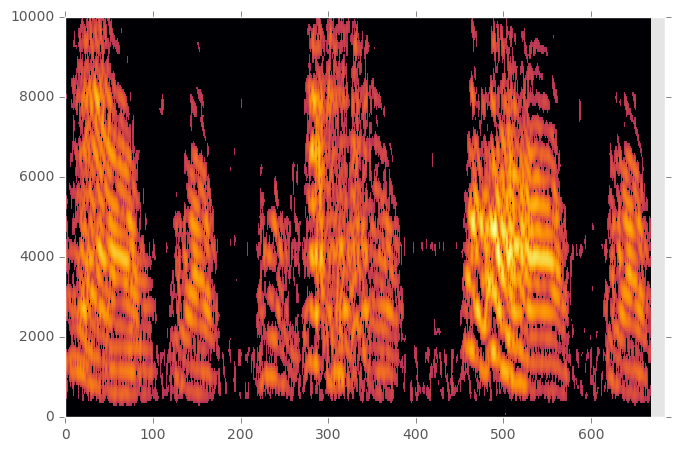

In [8]:
# from __future__ import division
# from scipy.signal import resample

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

n_samples = m_chunk.samples
bos = syn.load_syn_stream(bird, file_base='bos')[:,]

spectr_bos, ax = plot_spectrogram(bos[:], 
                                   0, 0, 30000,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

spectr_pattern, ax = plot_spectrogram(m_chunk.data[:].flatten(), 
                                   0, 0, 30000,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

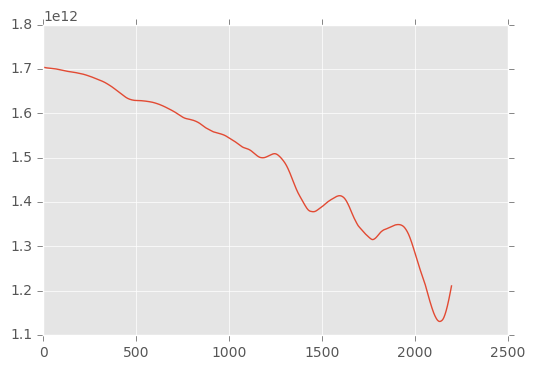

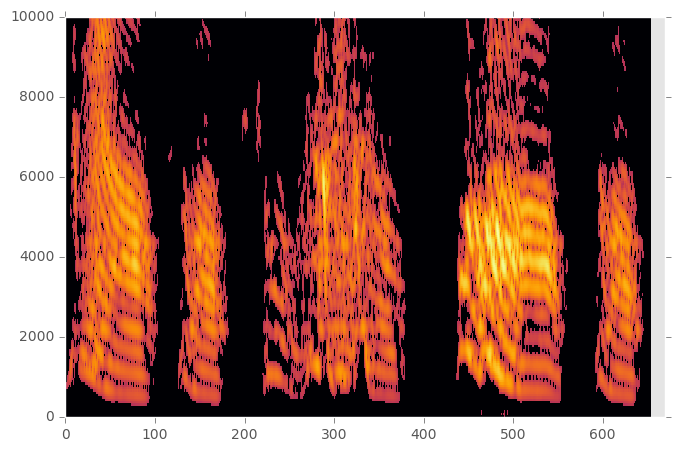

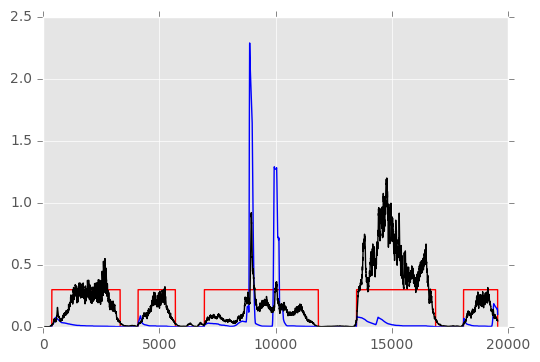

In [9]:
rundif = syn.running_diff(spectr_pattern, spectr_bos)
plt.plot(rundif)
offset = np.argmin(rundif)+512
syn_par = syn.load_syn_stream(bird, syn_sess=syn_sess)[offset: offset + n_samples,:]
bos = syn.load_syn_stream(bird, syn_sess=syn_sess, file_base='bos')[offset: offset + n_samples,]
synth_bos = syn.load_syn_stream(bird, syn_sess=syn_sess, file_base='song_synth_bos')[offset: offset + n_samples,]
env = syn.load_syn_stream(bird, syn_sess=syn_sess, file_base='env_bos')[offset: offset + n_samples,]
alpha, beta, envelope = [x[offset: offset + n_samples:] for x in syn.load_alpha_beta(bird, syn_sess=syn_sess)]
len_samples = min(n_samples, alpha.size)

spectr_bos, ax = plot_spectrogram(bos[:], 
                                   0, 0, 30000,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

plt.figure()
plt.plot(alpha,'r', beta, 'b', envelope/10, 'k')
fig_fname = os.path.join(os.path.split(m_path)[0], 'parameters.eps')
plt.savefig(fig_fname, format='eps', dpi=300)

In [16]:
# save the fitable streams
fns = et.file_names(bird, '002')
all_aligned = np.vstack([alpha, beta, envelope]).T
np.save(os.path.join(fns['folders']['stim'], 'par_stream_aligned.npy'), all_aligned)

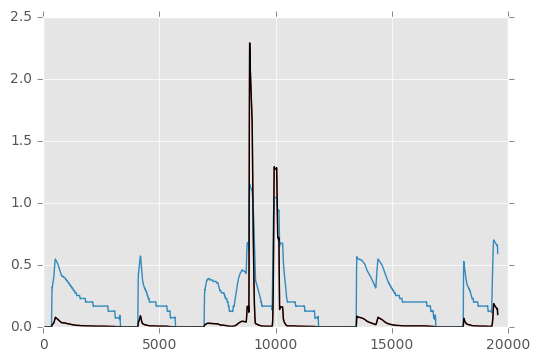

In [17]:
reload(syn)
plt.plot(beta)
plt.plot(syn.np_mulog(beta, 256))
plt.plot(syn.np_mulog_inv(syn.np_mulog(beta, 256), 256), 'k')

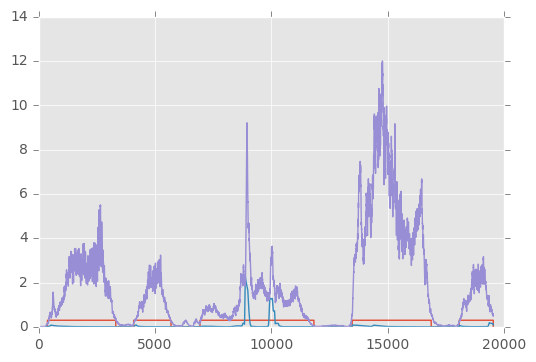

In [18]:
plt.plot(alpha)
plt.plot(beta)
plt.plot(envelope)

In [19]:
all_sess_units = um.list_sess_units(bird, sess)

In [20]:
m_starts = kwkf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())

In [21]:
# Neural data
shank = 0

kwik_file = et.open_kwik(bird, sess)
all_units = kwkf.list_units(kwik_file, group=shank, sorted=False)
units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print(all_units['clu'])


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


In [22]:
units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

selected unit 59, clu59


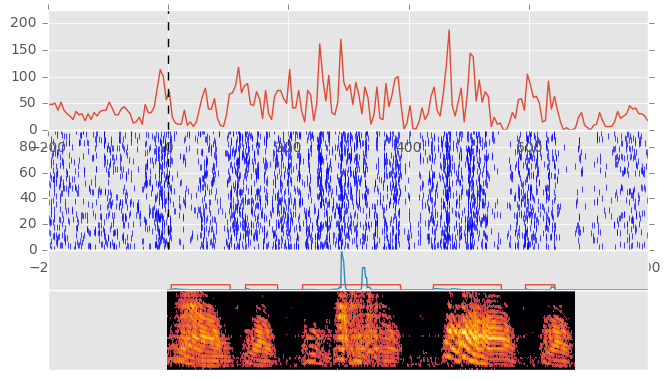

In [23]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|', rasterized=True)
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event):
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 800
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
    def show(self, i):
        i_clu = i
        self.select_unit(i_clu)
        print 'selected unit {0}, clu{1}'.format(i_clu, self.unit.clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        display(self.fig)
    
    def select_unit(self, unit_clu):
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)
    
    def init_event(self, event):
        self.event = event
        m_starts = kwkf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

vu = VizUnit(all_units, m_chunk, m)
widgets.interact(vu.show, i=(0, all_units['clu'].size-1, 1))

In [15]:
fig_fname = os.path.join(os.path.split(m_path)[0], 'rasters_{}.eps'.format(vu.unit.clu))
vu.fig.savefig(fig_fname, format='eps', dpi=100)

In [24]:
trials_train = np.arange(65)
trials_test = np.arange(65, 71)

In [25]:
logger.setLevel(logging.INFO)

In [30]:
#make a fit
from basic_viewing import units as u
reload(ld)
reload(u)

motiff_starts_kwik = kwkf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())
all_units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

bin_size = 7
history_bins = 15


bin_size_samples = int(bin_size*s_f/1000.)

trials_train = np.arange(85)
trials_test = np.arange(85, 91)

units_list = u.filter_unit_list(all_units_list, u.no_singularity_filter, 
                                motiff_starts_kwik[trials_train], len_samples,
                             bin_size=bin_size,
                              s_f=s_f,
                             history_bins=history_bins)

model_pars = bp.col_binned(np.array([alpha, beta, envelope]), bin_size_samples)/bin_size_samples

sv, sv_units = u.support_vector(motiff_starts_kwik[trials_train], len_samples, units_list, 
                      bin_size=bin_size, 
                      history_bins=history_bins+1)

#plt.plot(sv[43,:,:].sum(axis=1))
target = np.tile(model_pars[2], trials_train.size).reshape(trials_train.size, -1)
f = ld.fit_kernel(sv, target, history_bins+1)




In [39]:
print(len_samples)
print(sv.shape)
print(f.shape)

19546
(61, 109, 85)
(977,)


In [32]:
bin_samples = np.int(bin_size/1000.*s_f)
bin_samples

210

(61, 109, 6)


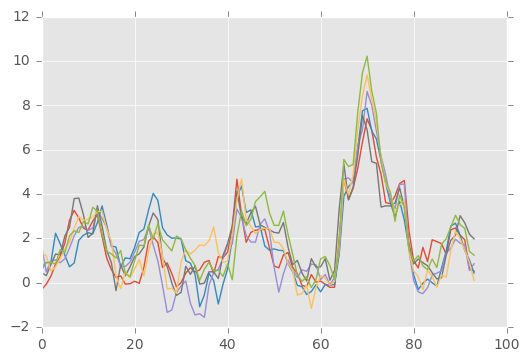

In [33]:
s_v_p, s_v_p_units = u.support_vector(motiff_starts_kwik[trials_test], len_samples, units_list, 
                      bin_size=bin_size, 
                      history_bins=history_bins+1, no_silent=False)
print(s_v_p.shape)
fitted = ld.kernel_predict(s_v_p, f)
#print(fitted.shape)
plt.plot(fitted.T);

In [34]:
history_bins

15

2017-02-01 10:47:01,606 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-01 10:47:03,623 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546
2017-02-01 10:47:04,650 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-01 10:47:05,451 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546


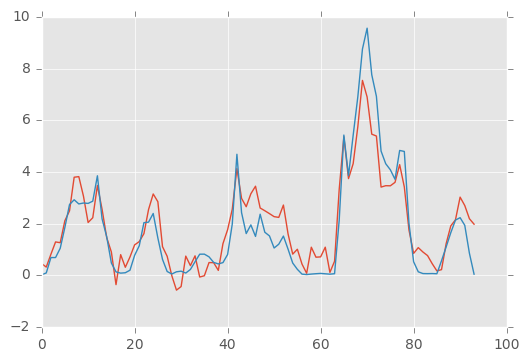

In [35]:
def transform_env(x):
    x[x<0] = 0
    return x

def transform_alpha(x):
    x[x<0.15] = 0
    x[x>=.15] = .3
    return x

def transform_beta(x):
    x[x<0] = 0
    return x

def mu_transform_beta(x):
    x[x<0] = 0
    return syn.np_mulog_inv(x, 256)


def linear_fit(unit_list, trial_starts, par_stream, bin_size=10, history_bins=15, s_f=30000):
    bin_size_samples = int(bin_size*s_f/1000.)
    len_samples = par_stream.shape[0]
    model_pars = bp.col_binned(np.array([par_stream]), bin_size_samples)/bin_size_samples
    s_v, s_v_units = u.support_vector(trial_starts, len_samples, units_list, 
                      bin_size=bin_size, 
                      history_bins=history_bins+1)
    target = np.tile(model_pars, trial_starts.size).reshape(trial_starts.size, -1)
    logger.info('sv shape {0}, target shape {1}, len_samples {2}'.format(s_v.shape, 
                                                                         target.shape, 
                                                                         len_samples))  

    return ld.fit_kernel(s_v, target, history_bins+1), s_v_units

def linear_predict(unit_list, trial_starts, len_samples, kernel, 
                   bin_size=10, 
                   history_bins=15, 
                   s_f=30000,
                   no_silent=False):    
    s_v, s_v_units = u.support_vector(trial_starts, len_samples, units_list, 
                      bin_size=bin_size, 
                      history_bins=history_bins+1,
                      no_silent=no_silent)
    
    logger.info('kernel shape {0}, sv_shape {1}, len_samples {2}'.format(kernel.shape, s_v.shape, len_samples))  
    return ld.kernel_predict(s_v, kernel)
    
    

def test_fit(units_list, train_starts, test_starts, par_stream, 
             bin_size=10, 
             history_bins=15, 
             s_f=30000,
             nonlinear_fun=lambda x: x):

    fitted_kernel, fit_units = linear_fit(units_list, train_starts, par_stream, 
               bin_size=bin_size, 
               history_bins=history_bins, 
               s_f=s_f)
    
    par_predict = linear_predict(fit_units, test_starts, par_stream.size, fitted_kernel,
                        bin_size=bin_size,
                        history_bins=history_bins,
                        s_f=s_f)
    
    bin_size_samples = int(bin_size * s_f / 1000.)
    binned_pars = bp.col_binned(np.array([par_stream]), bin_size_samples) / bin_size_samples
    target = np.tile(binned_pars, test_starts.size).reshape(test_starts.size, -1)
    kernel_predict = nonlinear_fun(par_predict)
    assert (train_starts.size > test_starts.size)
    residue = np.linalg.norm(kernel_predict - target) / np.linalg.norm(target)
    return fitted_kernel, kernel_predict, residue, target, fit_units


kernel_fit, units_fit = linear_fit(units_list, motiff_starts_kwik[trials_train], envelope, 
               bin_size=bin_size, 
               history_bins=history_bins, 
               s_f=s_f)

predict = linear_predict(units_list, motiff_starts_kwik[trials_test] , envelope.size, kernel_fit,
                        bin_size=bin_size,
                        history_bins=history_bins,
                        s_f=s_f)

fit_test = test_fit(units_list, 
                    motiff_starts_kwik[trials_train], 
                    motiff_starts_kwik[trials_test],
                    envelope,
                    bin_size=bin_size,
                    history_bins=history_bins,
                    s_f=s_f, 
                    nonlinear_fun = transform_env)

plt.plot(predict[3,:])
plt.plot(target[0,:])

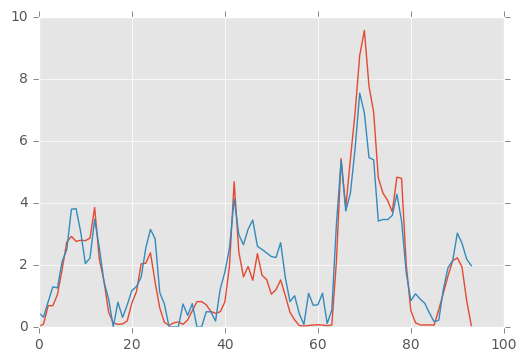

In [40]:
plt.plot(target[0,:])
plt.plot(fit_test[1][3,:])


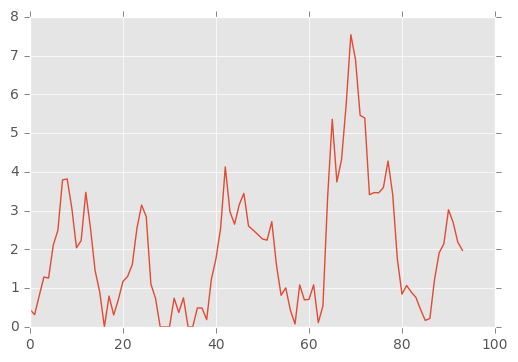

In [41]:
plt.plot(transform_env(predict)[3,:])

2017-02-06 08:05:39,491 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:05:40,010 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546


0.293202092373


2017-02-06 08:05:41,043 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:05:41,549 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546


0.22643652254


2017-02-06 08:05:42,591 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:05:43,206 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546


0.372843484636


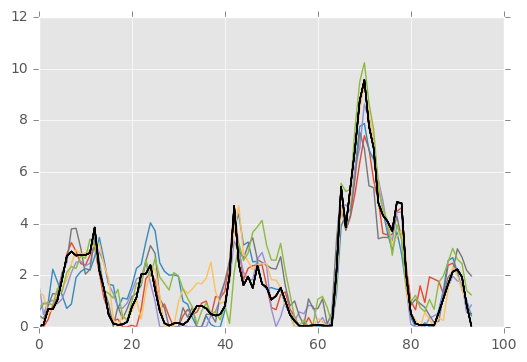

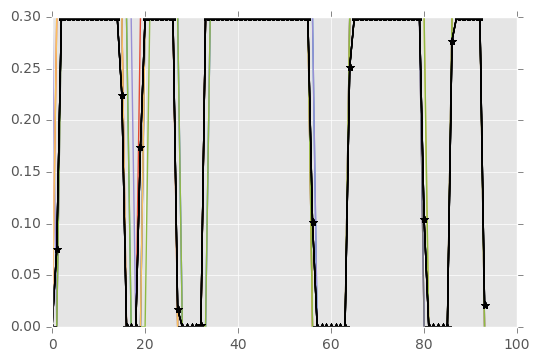

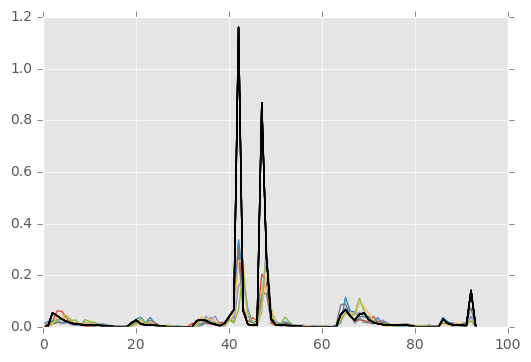

In [42]:
# test the fit and transform of envelope
env_test = test_fit(units_list, 
                    motiff_starts_kwik[trials_train], 
                    motiff_starts_kwik[trials_test],
                    envelope,
                    bin_size=bin_size,
                    history_bins=history_bins,
                    s_f=s_f,
                    nonlinear_fun=transform_env
                   )

plt.plot(env_test[1].T);
plt.plot(env_test[3].T, 'k')
print fit_test[2]

# test the fit and transform of alpha
alpha_test = test_fit(units_list, 
                    motiff_starts_kwik[trials_train], 
                    motiff_starts_kwik[trials_test],
                    alpha,
                    bin_size=bin_size,
                    history_bins=history_bins,
                    s_f=s_f,
                    nonlinear_fun = transform_alpha
                   )
plt.figure()
plt.plot(alpha_test[1].T);
plt.plot(alpha_test[3].T, 'k*-')
print alpha_test[2]

# test the fit and transform of beta
#plt.plot(syn.np_mulog(beta, 256))
beta_test = test_fit(units_list, 
                    motiff_starts_kwik[trials_train], 
                    motiff_starts_kwik[trials_test],
                    syn.np_mulog(beta, 256),
                    bin_size=bin_size,
                    history_bins=history_bins,
                    s_f=s_f,
                    nonlinear_fun = transform_beta
                   )
plt.figure()
plt.plot(mu_transform_beta(beta_test[1].T));
plt.plot(mu_transform_beta(beta_test[3].T), 'k')
print beta_test[2]

In [44]:
reload(u)
reload(ld)
def altogether_test(alpha, beta, env,
                    units_list, 
                    starts_train, 
                    starts_test,
                    bin_size=bin_size,
                    history_bins=history_bins,
                    s_f=s_f,
                    nl_alpha=transform_alpha, 
                    nl_beta=transform_beta, 
                    nl_env=transform_env):
    
    logger.info('Testing for all pars with bin_size={0}, history_size={1}:'.format(bin_size, history_bins))
    all_tests = [[] for i in range(5)]
    for par, nl in zip([alpha, beta, env], [nl_alpha, nl_beta, nl_env]):
        tested = test_fit(units_list, 
                        starts_train, 
                        starts_test,
                        par,
                        bin_size=bin_size,
                        history_bins=history_bins,
                        s_f=s_f,
                        nonlinear_fun = nl
                       )
        
        for i, test_res in enumerate(tested):
            all_tests[i].append(test_res)
    
    return [np.stack(t, axis=0) for t in all_tests]

every_test = altogether_test(alpha, syn.np_mulog(beta, 256), envelope,
                             units_list,
                             motiff_starts_kwik[trials_train],
                             motiff_starts_kwik[trials_test], 
                             bin_size=bin_size, 
                             history_bins=history_bins, 
                             s_f=s_f, 
                             nl_alpha = transform_alpha, 
                             nl_beta = transform_beta, 
                             nl_env = transform_env
                            )

2017-02-06 08:06:04,785 root         INFO     Testing for all pars with bin_size=7, history_size=15:
2017-02-06 08:06:05,902 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:06:06,456 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546
2017-02-06 08:06:07,486 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:06:08,007 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546
2017-02-06 08:06:08,996 root         INFO     sv shape (61, 109, 85), target shape (85, 94), len_samples 19546
2017-02-06 08:06:09,523 root         INFO     kernel shape (977,), sv_shape (61, 109, 6), len_samples 19546


In [45]:
#now try to synthesise for this test
def resample_no_interp(x, s_f, new_s_f, axis=0):
    assert(new_s_f>=s_f)
    n_repeats = np.int(np.ceil(new_s_f/s_f))
    return np.repeat(x, n_repeats, axis=axis)


def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T

n_test = 0
fitted_streams = every_test[3][:,n_test,:]


abe_streams = latent_to_stream(fitted_streams[0, :], 
                               syn.np_mulog_inv(fitted_streams[1, :]), 
                               fitted_streams[2, :])

abe_streams_rs = resample_no_interp(abe_streams, 1000./bin_size, 44100)

In [46]:
abe_streams[:,1]

array([ -0.00000000e+00,  -1.36280139e-03,  -3.90588054e-02,
        -3.00085588e-02,  -2.01733685e-02,  -1.40496365e-02,
        -9.33870751e-03,  -6.83403297e-03,  -5.69041616e-03,
        -4.88653453e-03,  -3.82942449e-03,  -3.60874250e-03,
        -3.60874282e-03,  -2.65613845e-03,  -1.95979512e-03,
        -8.71845710e-04,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -1.03651122e-02,  -1.75823163e-02,
        -6.72622523e-03,  -4.88652416e-03,  -3.72866002e-03,
        -3.60874215e-03,  -2.75928726e-03,  -1.16705242e-03,
        -5.16677603e-05,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -7.08723484e-05,
        -1.58827796e-02,  -1.84553094e-02,  -1.61108715e-02,
        -9.55936621e-03,  -5.87291836e-03,  -2.57272914e-03,
        -8.83699217e-03,  -2.78779062e-02,  -4.90385031e-02,
        -1.18117930e+00,  -4.46999107e-02,  -6.01783732e-03,
        -3.60874235e-03,  -4.13397085e-03,  -8.52362479e-01,
        -2.31409293e-01,

In [47]:
def resample_interp(y, s_f, new_s_f):
    print s_f
    t = np.arange(y.size)/s_f
    print t[-1]
    print 1./new_s_f
    t_interp = np.arange(t[-1]*new_s_f)/new_s_f
    f = sp.interpolate.interp1d(t, y, kind='linear')
    return f, t, t_interp

interp_stream, t, t_interp = resample_interp(abe_streams[:,1], 1000./bin_size, 44100.)
#plt.plot(interp_stream)

142.857142857
0.651
2.26757369615e-05


In [48]:
abe_streams[:,1].size

94

In [49]:
t_interp.size

28710

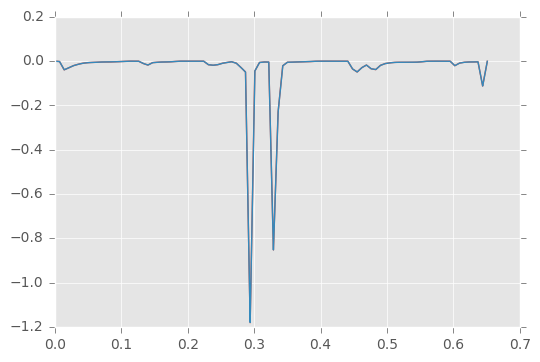

In [50]:
plt.plot(t, interp_stream(t))
plt.plot(t_interp, interp_stream(t_interp))

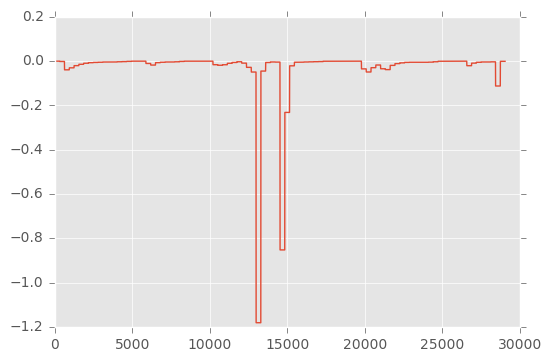

In [51]:
plt.plot(abe_streams_rs[:,1])

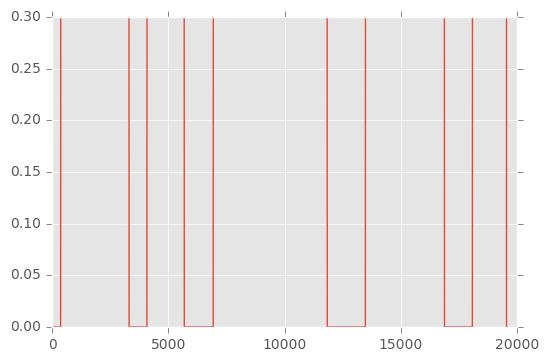

In [52]:
plt.plot(alpha)

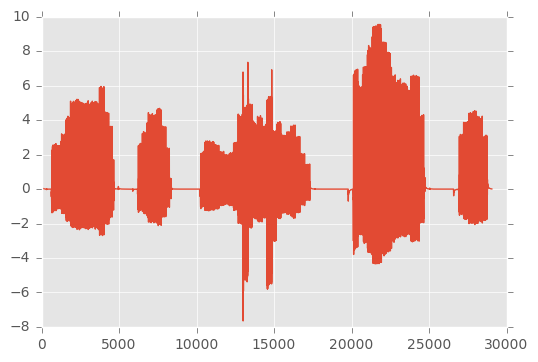

In [53]:
from dynamo import finch as zf
s_s = zf.make_song(abe_streams_rs)
plt.plot(s_s[:, 0])

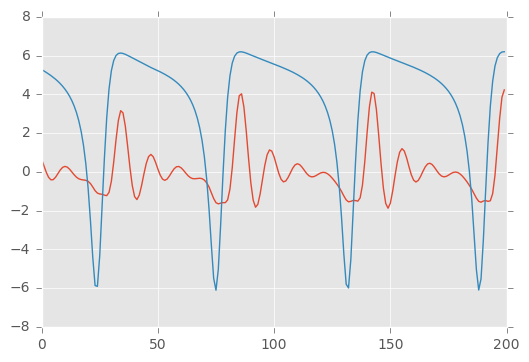

In [54]:
plt.plot(s_s[1500:1700, :])

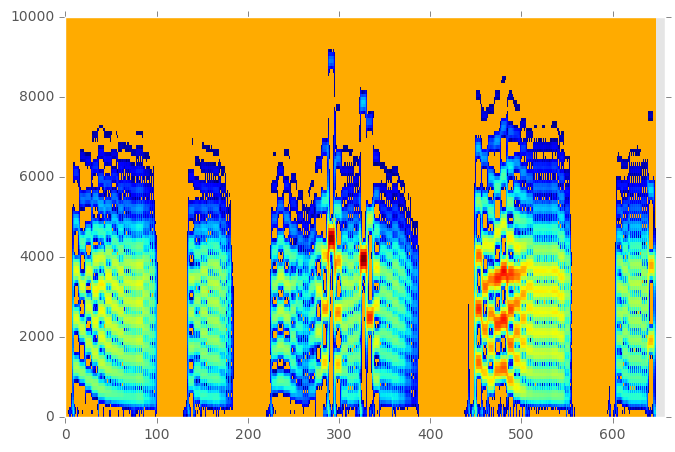

In [55]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

spectr_bos, ax = plot_spectrogram(s_s[:, 0], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

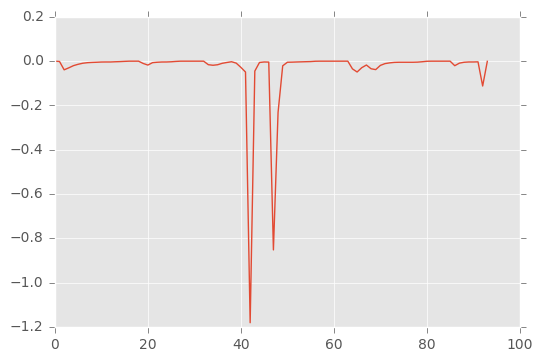

In [56]:
plt.plot(abe_streams[:,1])

In [316]:
resample_no_interp(arr, 1, 2, axis=0).shape

(6, 2)

2017-01-18 16:46:41,552 root         INFO     Testing for all pars with bin_size=7, history_size=15:
2017-01-18 16:46:43,023 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:43,534 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503
2017-01-18 16:46:44,930 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:45,365 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503
2017-01-18 16:46:46,700 root         INFO     sv shape (56, 108, 65), target shape (65, 93), len_samples 19503
2017-01-18 16:46:47,132 root         INFO     kernel shape (897,), sv_shape (56, 108, 6), len_samples 19503


In [283]:
every_test[3].shape

(3, 6, 93)

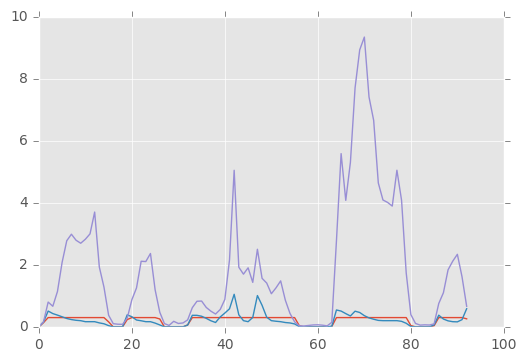

In [286]:
plt.plot(every_test[3][:, 0, :].T);

In [244]:
bins = [5, 6, 7, 8, 9, 10, 12, 15]
histories = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 27]
tests_sweep = []
for bs in bins:
    bs_sweep = []
    for hs in histories:
        logger.info('Testing with bs={0}, hs={1}:'.format(bs, hs))
        ev_tst = altogether_test(alpha, syn.np_mulog(beta, 256), envelope,
                             units_list,
                             motiff_starts_kwik[trials_train],
                             motiff_starts_kwik[trials_test], 
                             bin_size=bs, 
                             history_bins=hs, 
                             s_f=s_f, 
                             nl_alpha = transform_alpha, 
                             nl_beta = transform_beta, 
                             nl_env = transform_env
                            )
        bs_sweep.append(ev_tst)
    tests_sweep.append(bs_sweep)

2016-12-08 17:22:58,779 root         INFO     Testing with bs=5, hs=5:
2016-12-08 17:22:58,783 root         INFO     Testing for all pars with bin_size=5, history_size=5:
2016-12-08 17:23:01,944 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:04,908 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:07,814 root         INFO     kernel shape (337,), sv_shape (56, 136, 6), len_samples 19503
2016-12-08 17:23:07,821 root         INFO     Testing with bs=5, hs=6:
2016-12-08 17:23:07,822 root         INFO     Testing for all pars with bin_size=5, history_size=6:
2016-12-08 17:23:10,742 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08 17:23:13,676 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08 17:23:16,616 root         INFO     kernel shape (393,), sv_shape (56, 137, 6), len_samples 19503
2016-12-08

In [232]:
len(tests_sweep)
n_bs

7

In [235]:
tests_sweep[5][2][2]

array([ 0.18780506,  0.29427109,  0.18832537])

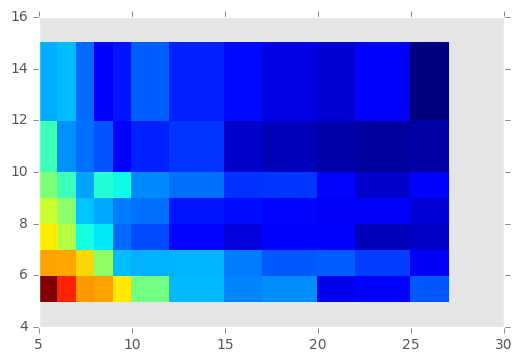

In [274]:
import itertools
n_bs = len(bins)
n_hs = len(histories)

res_array = np.zeros([n_bs, n_hs, 3])
for b, h in itertools.product(range(n_bs), range(n_hs)):
    res_array[b, h, :] = tests_sweep[b][h][2]

plt.pcolormesh(histories, bins, res_array[:,:,0])

(660,)


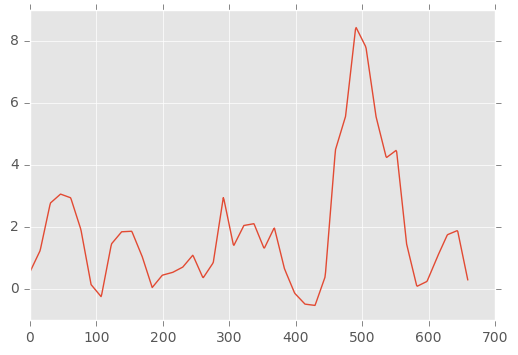

In [19]:
def resample_interp(x, s_f, new_s_f):
    t = np.linspace(0, x.size/s_f, x.size)
    #print t
    new_t = np.linspace(0, x.size/s_f, np.int(x.size*new_s_f/s_f))
    print new_t.shape
    return np.interp(new_t, t, x)

y = resample_interp(predict[3,:], 1, bin_size)
plt.plot(y)


In [23]:
ms_env.shape

(1, 651)

In [20]:
from decoder import linear
reload(ld)
big_r = ld.make_big_r(sv, history_bins)
big_r.shape

(2925, 1121)

In [21]:
def test_prediction(target, predict):
    

IndentationError: expected an indented block (<ipython-input-21-8dc4f6b324ac>, line 2)

In [100]:
motiff_starts_kwik = kwf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())
# make an array of n_bins * n_units * n_starts

bin_size = 5
history_bins = 20

# n_ms = int(len_samples/s_f*1000.)
# bin_size_samples = int(bin_size*s_f/1000)

# n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
# n_starts = motiff_starts_kwik.size
# n_units = all_units.size


# sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)
# model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)

# for i, unit_meta in enumerate(all_units):
#     clu = unit_meta['clu']
#     unit = Unit(clu, kwik_file=kwik_file)
#     rs = unit.get_raster(motiff_starts_kwik - int(history_bins*bin_size*s_f/1000), 
#                          n_ms + bin_size*(history_bins-1), 
#                          span_is_ms=True, 
#                          return_ms=True)
#     sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
# good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
# god_vec = sup_vec[good_units,:,:][0]

def gimme_good_vec(starts, len_samples, all_units, kwik_file, alpha, beta,
                   s_f=30000, bin_size=10, history_bins=1):
    n_ms = int(len_samples/s_f*1000.)
    bin_size_samples = int(bin_size*s_f/1000.)
    
    n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
    n_starts = starts.size
    n_units = all_units.size
    
    model_pars = bp.col_binned(np.array([alpha, beta, envelope]), bin_size_samples)
    sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)  
    for i, unit_meta in enumerate(all_units):
        clu = unit_meta['clu']
        unit = Unit(clu, kwik_file=kwik_file)
        rs = unit.get_raster(starts - int(history_bins*bin_size*s_f/1000), 
                             n_ms + bin_size*(history_bins-1), 
                             span_is_ms=True, 
                             return_ms=True)
        sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
    good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
    
    return sup_vec[good_units,:,:][0], model_pars

def unit_array(god_vec, i_u, i_tr, m, N):    
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m, N):
    x = np.hstack([unit_array(god_vec, u, i_tr, m, N) for u in range(god_vec.shape[0])])
    return np.hstack([np.ones([x.shape[0], 1]), x])

def fit_kernel(god_vec, target, trials, history_bins=10):
    # with this simple support vector make a linear decoder as in warland
    N = history_bins # history bins
    
    v = god_vec.shape[0] #number of units
    M = god_vec.shape[2] #len of recording
    m = M-N
    
    bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in trials])
    s = np.tile(target[:m], trials.size)
    c = np.dot(bigR.T, bigR)
    rc = np.dot(bigR.T, s)
    f = np.dot(np.linalg.inv(c), rc)
    
    return f

def test_kernel(god_vec, target, kernel, trials, history_bins):
    N = history_bins
    M = god_vec.shape[2]
    m = M - N
    all_fits = np.vstack([np.dot(all_units_array(god_vec, tr_test, m, N), kernel) for tr_test in trials])
    all_fits[all_fits<0]=0
    
    all_residual = np.einsum('ij,ij', all_fits - target[:m], all_fits - target[:m])
    err = all_residual/np.einsum('i,i', target[:m], target[:m])  
    return err, all_fits


god_vec, model_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                                     s_f=30000, 
                                     bin_size=bin_size, 
                                     history_bins=1)

# with this simple support vector make a linear decoder as in warland
N = history_bins# history bins
M = god_vec.shape[2] #len of recording
m = M-N

n_trials = 65
f_fit_alpha = fit_kernel(god_vec, model_pars[0,:], np.arange(n_trials), history_bins=N)
f_fit_beta = fit_kernel(god_vec, model_pars[1,:], np.arange(n_trials), history_bins=N)
f_fit_env = fit_kernel(god_vec, model_pars[2,:], np.arange(n_trials), history_bins=N)
f_fit_betalog = fit_kernel(god_vec, mulog_vec(model_pars[1,:m]/350, 512), np.arange(n_trials), history_bins=N)

tr_test = 69
u_alpha = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_alpha)
u_beta = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_beta)
u_betalog = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_betalog)
u_env = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_env)

plt.plot(u_alpha)
plt.plot(model_pars[0,:m])

d, alfits = test_kernel(god_vec, model_pars[1,:], f_fit_beta, np.arange(67,69), N)


ValueError: could not broadcast input array from shape (71,137) into shape (71,138)

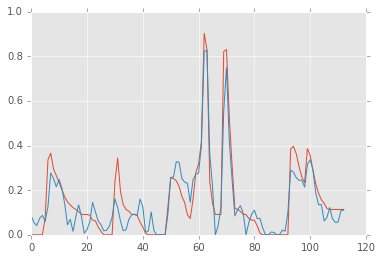

In [17]:
plt.plot(mulog_vec(model_pars[1,:m]/350, 512))
u_betalog[u_betalog<0]=0
plt.plot(u_betalog)

In [101]:
sup_vec

NameError: name 'sup_vec' is not defined

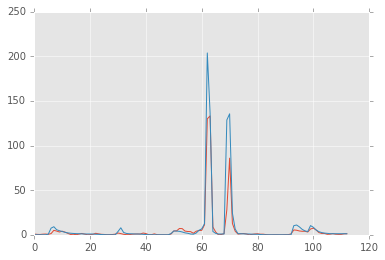

In [18]:
def inverse_mulog_vec(y, mu=256):
    return np.sign(y) * (np.power((1. + mu)*np.ones_like(y), np.fabs(y)) - 1.)/mu

beta = inverse_mulog_vec(u_betalog)*350
plt.plot(beta)
plt.plot(model_pars[1,:m])

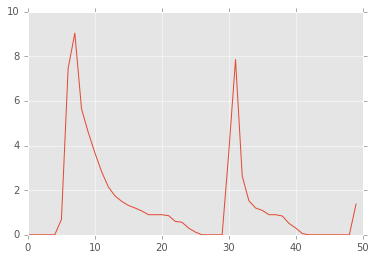

In [26]:
plt.plot(model_pars[1,:50])

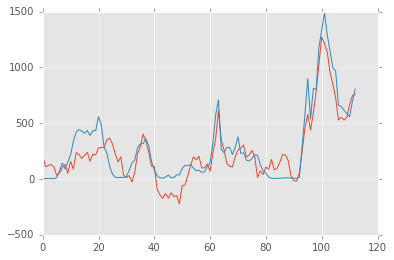

In [19]:
plt.plot(u_env)
plt.plot(model_pars[2,:m])

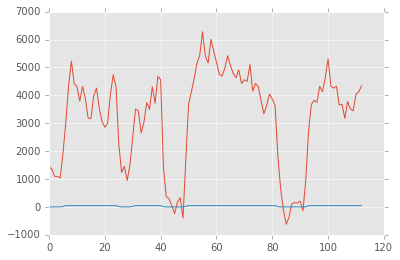

In [20]:
#u_alpha[u_alpha<45]=0.
#u_alpha[u_alpha>45]=-.15
plt.plot(u_alpha*100)
plt.plot(model_pars[0,:m])

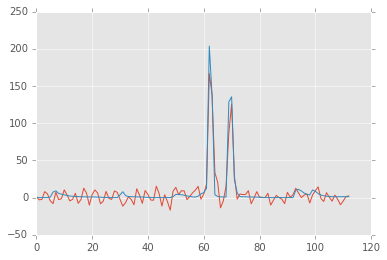

In [27]:
plt.plot(u_beta)
plt.plot(model_pars[1,:m])

In [21]:
def resample_interp(x, s_f, new_s_f):
    t = np.linspace(0, x.size/s_f, x.size)
    #print t
    new_t = np.linspace(0, x.size/s_f, np.int(x.size*new_s_f/s_f))
    print new_t.shape
    return np.interp(new_t, t, x)
